In [1]:
import time
!pip install pandas_datareader

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader as web

import pandas_datareader.data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

    100% |████████████████████████████████| 112kB 2.1MB/s ta 0:00:01
    100% |████████████████████████████████| 5.8MB 99kB/s  eta 0:00:01    94% |██████████████████████████████▏ | 5.5MB 26.9MB/s eta 0:00:01
  Running setup.py bdist_wheel for requests-ftp ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/2a/98/32/37195e45a3392a73d9f65c488cbea30fe5bad76aaef4d6b020
  Running setup.py bdist_wheel for wrapt ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/48/5d/04/22361a593e70d23b1f7746d932802efe1f0e523376a74f321e
Successfully built requests-ftp wrapt
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/srv/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/srv/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import os
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

In [4]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2016-01-01', '%Y-%m-%d') 
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [5]:
crypto = ['BTC', 'ETH', 'LTC','XRP']

crypto_data = {}
for coin in crypto:
    coinpair = 'USDT_{}'.format(coin)
    crypto_price_df = get_crypto_data(coinpair)
    crypto_data[coin] = crypto_price_df

Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1451606400.0&end=1535631490.021362&period=86400 at USDT_BTC
Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1451606400.0&end=1535631490.021362&period=86400 at USDT_ETH
Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_LTC&start=1451606400.0&end=1535631490.021362&period=86400 at USDT_LTC
Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_XRP&start=1451606400.0&end=1535631490.021362&period=86400 at USDT_XRP


In [8]:
database = pd.concat([crypto_data['BTC']['close'],crypto_data['ETH']['close'],crypto_data['LTC']['close'],crypto_data['XRP']['close']], axis=1)

In [9]:
database.columns = ['BTC-USD', 'ETH-USD', 'LTC-USD','XRP-USD']
database.head()

,BTC-USD,ETH-USD,LTC-USD,XRP-USD
date,,,,
2016-01-01,434.990000,0.959136,3.563049,0.005999
2016-01-02,436.949900,0.957000,3.569990,0.006127
2016-01-03,428.140000,0.960499,3.435230,0.006149
2016-01-04,432.000011,0.962224,3.435230,0.006149
2016-01-05,430.376774,0.939382,3.435234,0.006149


In [10]:
# База данных по доходностям
returns_database=database.pct_change()
returns_database.head()

,BTC-USD,ETH-USD,LTC-USD,XRP-USD
date,,,,
2016-01-01,NaN,NaN,NaN,NaN
2016-01-02,0.004506,-0.002227,0.001948,0.021299
2016-01-03,-0.020162,0.003656,-0.037748,0.003702
2016-01-04,0.009016,0.001796,0.000000,0.000000
2016-01-05,-0.003757,-0.023738,0.000001,0.000000


In [12]:
#Дневные и годовые доходности и ковариации
daily_returns=returns_database.mean() 
daily_cov=returns_database.cov() 
annual_returns=daily_returns*250
annual_cov=daily_cov*250

    100% |████████████████████████████████| 215kB 2.0MB/s ta 0:00:01
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


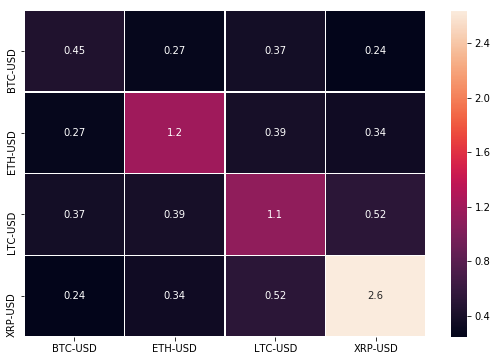

In [14]:
!pip install seaborn
import seaborn as sns
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(annual_cov, annot=True, linewidths=.5, ax=ax)
#plt.show()
plt.savefig("out.svg", transparent = True)

In [17]:
#Задаем количество портфелей
assets_num=len(crypto)
portfolios_num=50000

In [19]:
np.random.seed(101)
#Создаем пустые списки для доходности, волатильности, весов и коэффицента Шарпа для каждого из портфелей
portfolio_returns=[]
portfolio_volatility=[]
portfolio_weights=[]
sharpe_ratio=[]

In [20]:
#Создание 50000 потфелей с разными весами акций
for portfolio in range(portfolios_num):
    weights=np.random.random(assets_num)
    weights /= np.sum(weights)
    port_return=np.dot(weights,annual_returns)
    port_volatility=np.sqrt(np.dot(weights.T,np.dot(annual_cov,weights)))
    sharpe=port_return/port_volatility
    sharpe_ratio.append(sharpe)
    portfolio_returns.append(port_return)
    portfolio_volatility.append(port_volatility)
    portfolio_weights.append(weights)

In [21]:
chosen_companies = crypto
#Создаем таблицу с портфелями
portfolio={'Доходность':portfolio_returns, 'Риск':portfolio_volatility, 'Коэффицент Шарпа':sharpe_ratio}
for counter,symbol in enumerate(chosen_companies):
    portfolio[symbol] = [Weight[counter]*100 for Weight in portfolio_weights]

In [22]:
df=pd.DataFrame(portfolio)
df.head()

,Доходность,Риск,Коэффицент Шарпа,BTC,ETH,LTC,XRP
0,1.578191,0.732176,2.155482,40.122278,44.338777,2.212343,13.326603
1,1.668383,0.823791,2.025250,25.196293,30.660756,11.286547,32.856404
2,1.352377,0.732630,1.845921,39.692323,10.448593,30.488210,19.370874
3,1.583732,0.814517,1.944383,8.400212,36.280908,44.588250,10.730630
4,1.634071,0.831760,1.964595,4.937623,35.663514,43.075986,16.322878


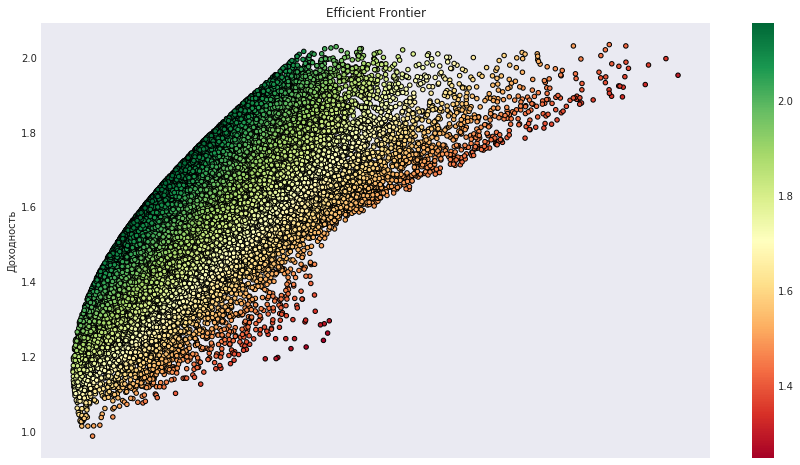

In [24]:
#Рисуем график портфелей 

plt.style.use('seaborn-dark')
df.plot.scatter(x='Риск',y='Доходность', c=sharpe_ratio, cmap='RdYlGn', edgecolors='black',figsize=(15,8))
plt.xlabel('Риск')
plt.ylabel('Доходность')
plt.title('Efficient Frontier')
plt.show()

In [25]:
#Выбираем портфели с максимальным коэффицентом Шарпа и минимальной волатильностью
min_volatility=df['Риск'].min()
max_sharp=df['Коэффицент Шарпа'].max()

min_vol_port=df[df['Риск']==min_volatility]
max_sharp_port=df[df['Коэффицент Шарпа']==max_sharp]

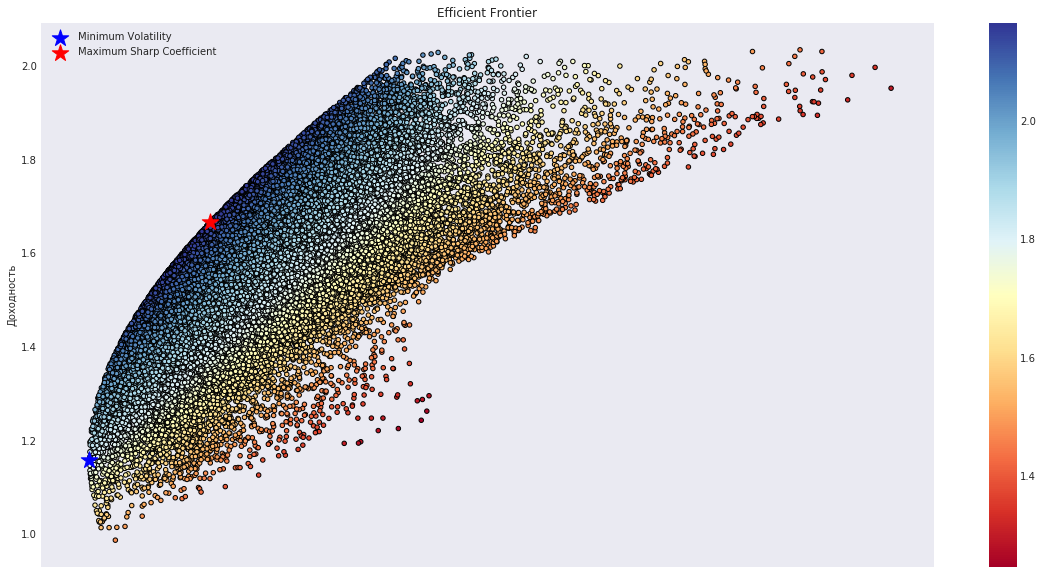

In [26]:
plt.style.use('seaborn-dark')
df.plot.scatter(x='Риск',y='Доходность', c=sharpe_ratio, cmap='RdYlBu', edgecolors='black',figsize=(20,10))
plt.scatter(x=min_vol_port['Риск'],y=min_vol_port['Доходность'], marker='*', c='Blue', s=300, label='Minimum Volatility')
plt.scatter(x=max_sharp_port['Риск'],y=max_sharp_port['Доходность'],  marker='*', c='Red', s=300, label='Maximum Sharp Coefficient')

plt.xlabel('Риск')
plt.ylabel('Доходность')
plt.title('Efficient Frontier')
plt.legend()
plt.show()

                  32388
Доходность         1.67
Риск               0.77
Коэффицент Шарпа   2.16
BTC               32.15
ETH               47.96
LTC                2.07
XRP               17.82


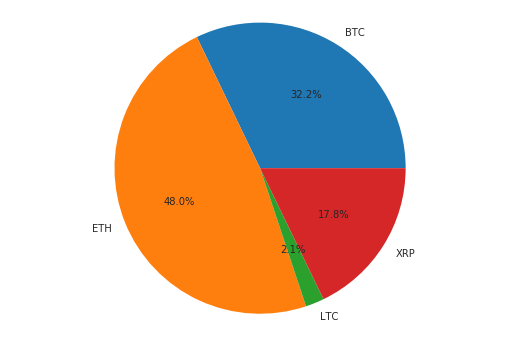

In [27]:
#Portfolio with max. Sharp Ratio  (red point)
print(max_sharp_port.T.round(2))


labels=list(max_sharp_port.columns)[3:]
data=max_sharp_port.iloc[0,3:]


fig,ax=plt.subplots(figsize=(9,6))
ax.pie(data,labels=labels,autopct='%1.1f%%')
plt.axis('equal')
plt.show()

                  36749
Доходность         1.16
Риск               0.64
Коэффицент Шарпа   1.81
BTC               76.62
ETH               12.64
LTC                4.18
XRP                6.56


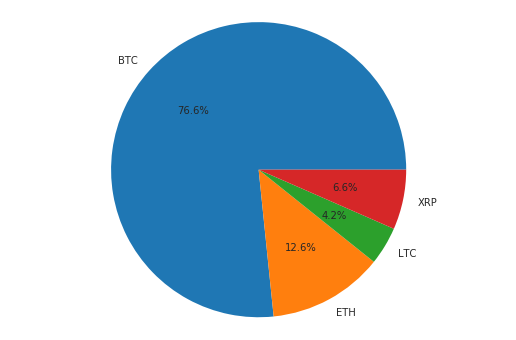

In [28]:
#Portfolio with min. volatility (blue point)
print(min_vol_port.T.round(2))


labels=list(min_vol_port.columns)[3:]
data=min_vol_port.iloc[0,3:]


fig,ax=plt.subplots(figsize=(9,6))
ax.pie(data,labels=labels,autopct='%1.1f%%')
plt.axis('equal')
plt.show()